## In this discussion, we will be creating an undirected network using an edgelist of a Facebook friend network and study it's various properties.

In [18]:
# Installing the required packages
install.packages("ggplot2")
library(ggplot2)

if (!require("igraph")) install.packages("igraph")
library ("igraph")


The downloaded binary packages are in
	/var/folders/ht/_8n2bpc13fq2fyn45f1mzw5c0000gn/T//RtmpNpkT8V/downloaded_packages


## Creating the Facebook network using the edgelist

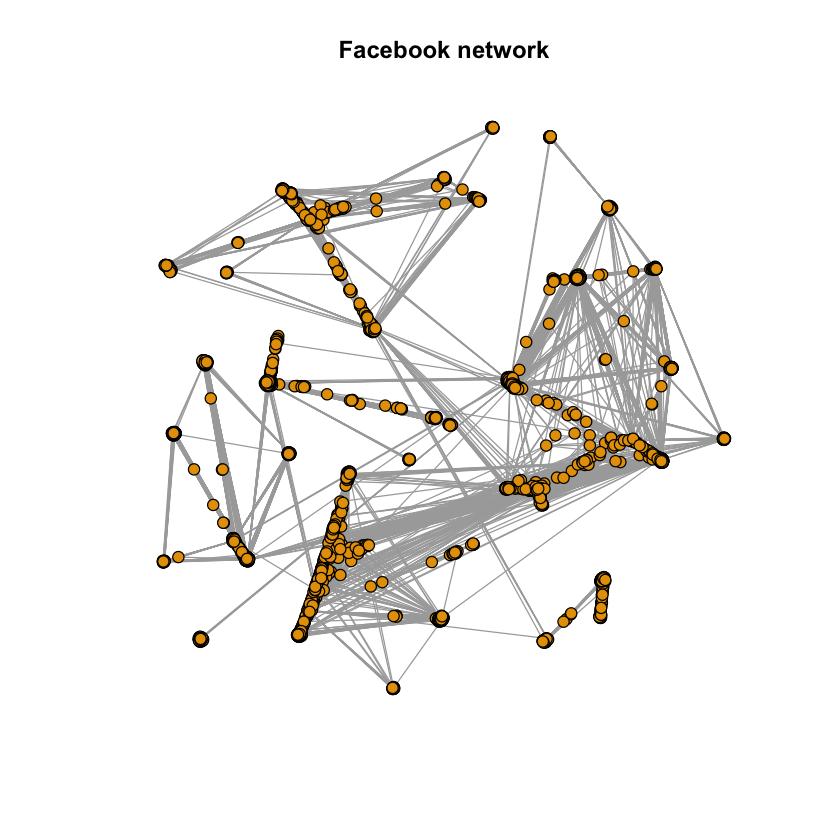

In [19]:
fb_combined = read.table("facebook_combined.txt")
tmp_mat = as.matrix(fb_combined)+1
g = graph.edgelist(tmp_mat,directed=FALSE) 
plot(g, edge.arrow.size=.1, vertex.size=4, vertex.label=NA, main="Facebook network")

## Basic properties of the Facebook network

## Connectivity properties

In [20]:
sprintf('Number of nodes: %s',vcount(g))
sprintf('Number of edges: %s',ecount(g))
print(paste("Network connected: ", is_connected(g)))
print(paste("Network diameter: ", diameter(g)))

[1] "Number of nodes: 4039"

[1] "Number of edges: 88234"

[1] "Network connected:  TRUE"
[1] "Network diameter:  8"


## Degree distribution

[1] "Average network degree:  522.5"


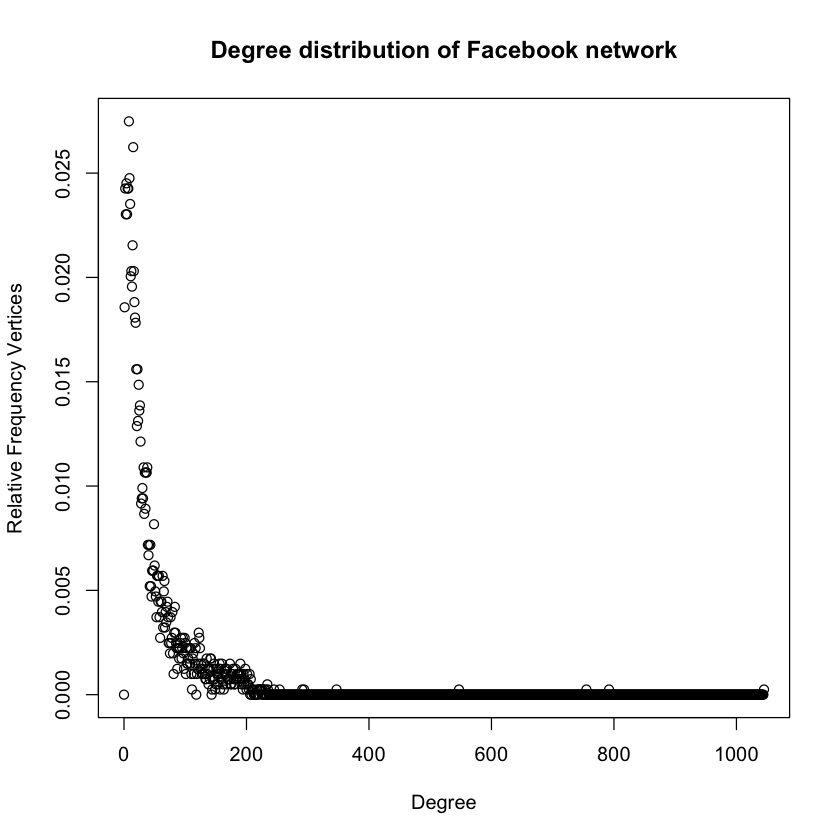

In [22]:
unique_degrees = unique(sort(degree(g)))
if (unique_degrees[1]!=0) {
    unique_degrees = seq(0,max(unique_degrees))
}
dd = degree_distribution(g)

plot(unique_degrees, dd, main="Degree distribution of Facebook network", xlab="Degree", ylab="Relative Frequency Vertices")
print(paste("Average network degree: ", mean(unique_degrees)))

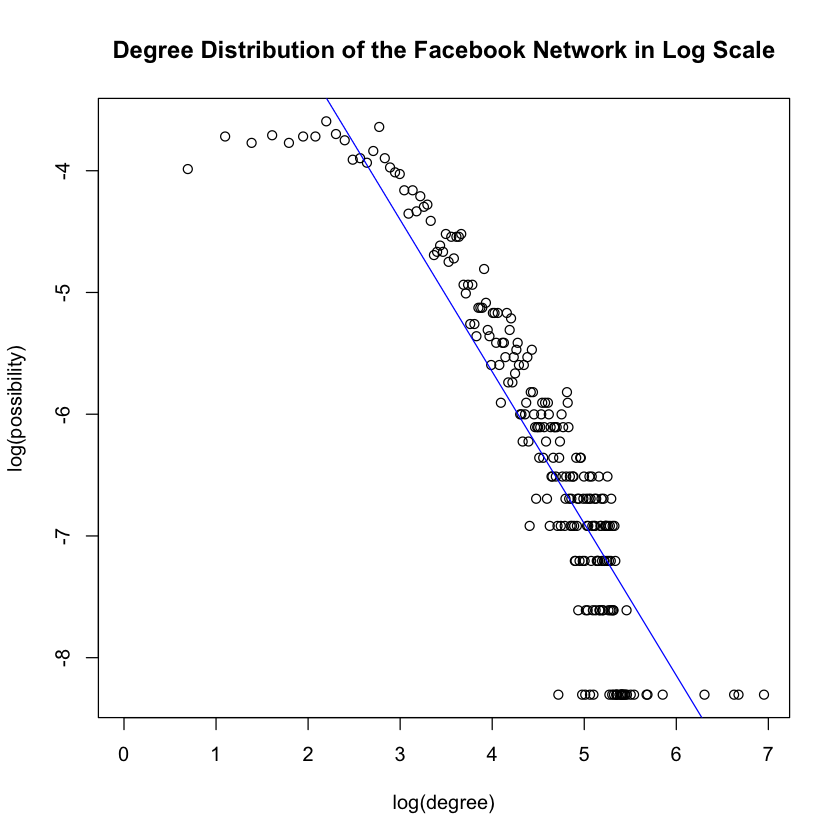

In [23]:
log_degree = log(c(1:length(degree.distribution(g))))
log_distr = log(degree.distribution(g))

log_degree_x = log_degree[-which(is.infinite(log_distr))]
log_distr_y = log_distr[-which(is.infinite(log_distr))]

lr = lm(log_distr_y~log_degree_x)
plot(log_degree, log_distr, main="Degree Distribution of the Facebook Network in Log Scale",xlab="log(degree)",ylab="log(possibility)")
abline(lr, col="blue")



## Creating a personalized network of an user and studying it's various properties

## Creating the personalized network

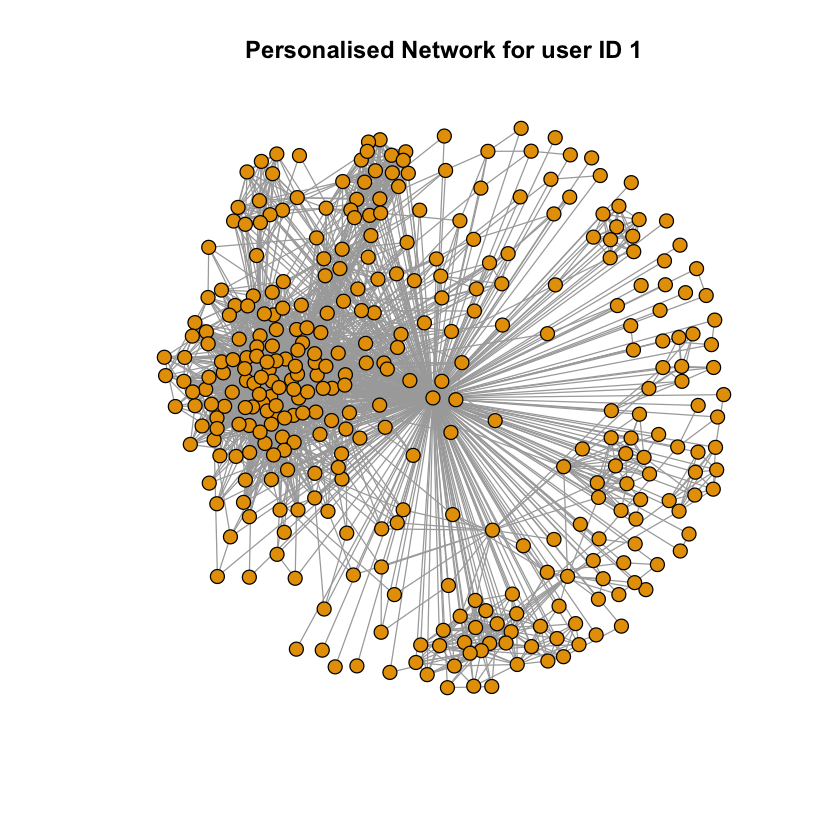

In [25]:
g1 = make_ego_graph(g, order=1,nodes=c('1'))[[1]]
test = plot(g1, edge.arrow.size=.1, vertex.size=5, vertex.label=NA,main="Personalised Network for user ID 1")


## Connectivity properties of the personalized network

In [26]:
print(paste("Network ID 1 number of nodes: ", vcount(g1)))
print(paste("Network ID 1 number of edges: ", ecount(g1)))
print(paste("Network connected: ", is_connected(g1)))
print(paste("Network diameter: ", diameter(g1)))

[1] "Network ID 1 number of nodes:  348"
[1] "Network ID 1 number of edges:  2866"
[1] "Network connected:  TRUE"
[1] "Network diameter:  2"


## Extracting the core nodes of the facebook network

In [27]:

facebook_net = g
core_nodes = c()

for (i in degree(facebook_net)){
  if (i > 200) {
    core_nodes = c(core_nodes, i)
  }
}

print(paste('Number of core nodes:', length(core_nodes)))
print(paste('Average Degree:', mean(core_nodes)))

[1] "Number of core nodes: 40"
[1] "Average Degree: 279.375"


## Exploring the community structure of the core nodes personalized networks

In [12]:
#helper function for community dection algorithms
community_detect = function(g, node_id) {
  fg <- fastgreedy.community(g)
  eb <- edge.betweenness.community(g)
  info_map <- infomap.community(g)

  cat("Node:", node_id, "\n") #make print output separator
  print(sprintf('Fast-Greedy Modularity Node %s is %s', node_id, modularity(fg)))
  print(sprintf('Edge-Betweenness Modularity Node %s is %s', node_id, modularity(eb)))
  print(sprintf('Info Map Modularity Node %s is %s', node_id, modularity(info_map)))
 
  
  plot(g, mark.groups = groups(fg), edge.arrow.size=0.1, vertex.color=fg$membership, vertex.size=5, vertex.label = NA, main=sprintf("Fast-Greedy; Core Node: %s", node_id))
  

  
  plot(g, mark.groups = groups(eb), edge.arrow.size=0.1, vertex.color=eb$membership, vertex.size=5, vertex.label = NA, main=sprintf("Edge-Betweenness; Core Node: %s", node_id))
  

  
  plot(g, mark.groups = groups(info_map), edge.arrow.size=0.1, vertex.color=info_map$membership, vertex.size=5, vertex.label = NA, main=sprintf("Info Map; Core Node: %s", node_id))
  
  cat('\n')
}

Node: 1 
[1] "Fast-Greedy Modularity Node 1 is 0.413101372834235"
[1] "Edge-Betweenness Modularity Node 1 is 0.353302172546335"
[1] "Info Map Modularity Node 1 is 0.389118471050977"


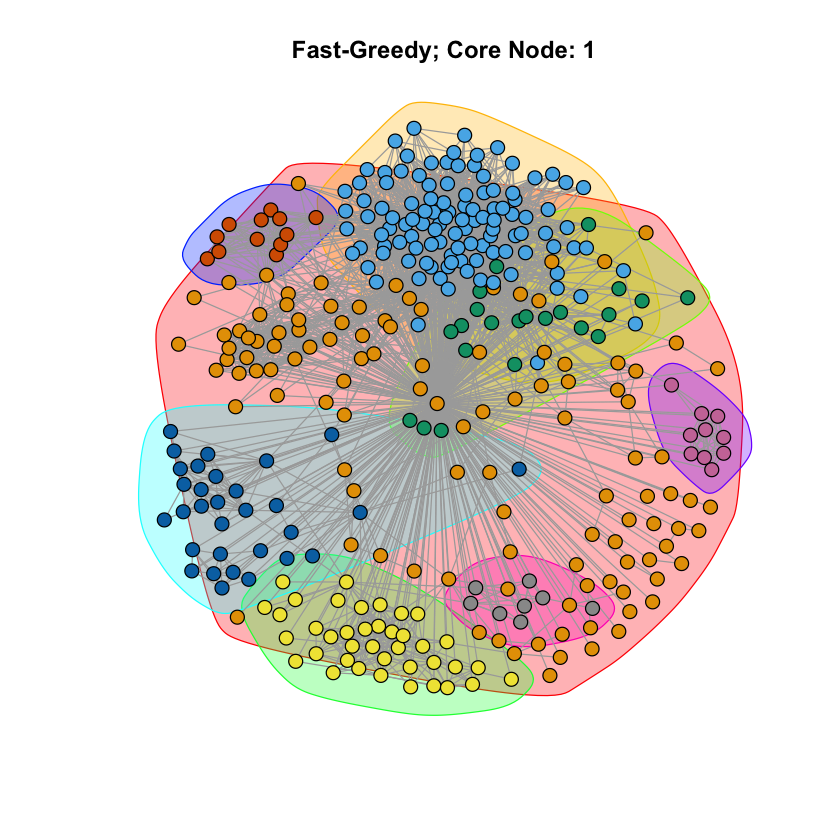

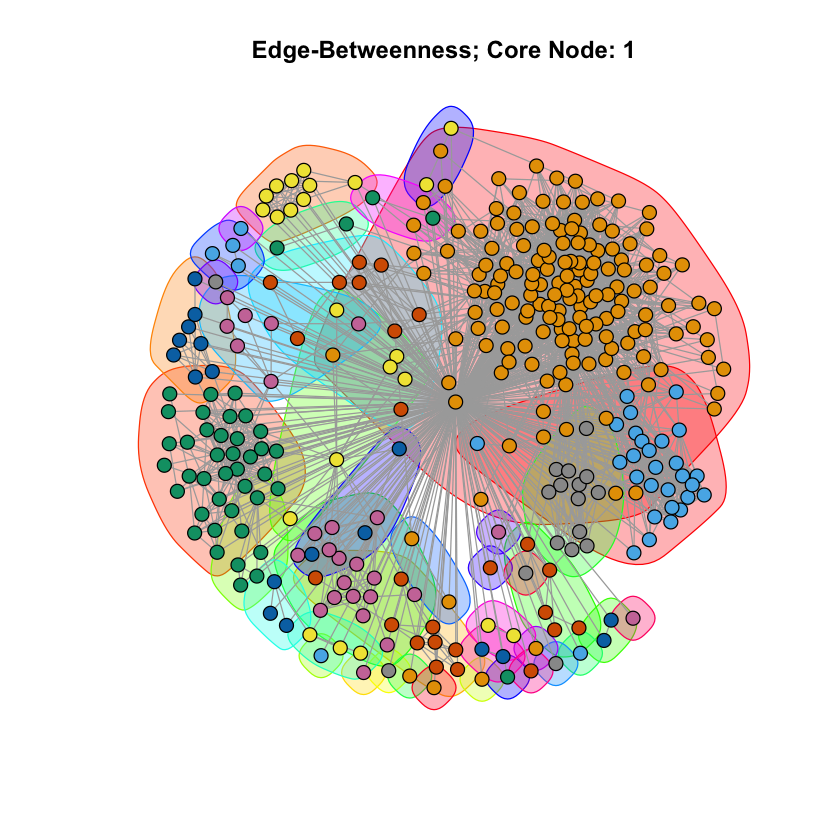

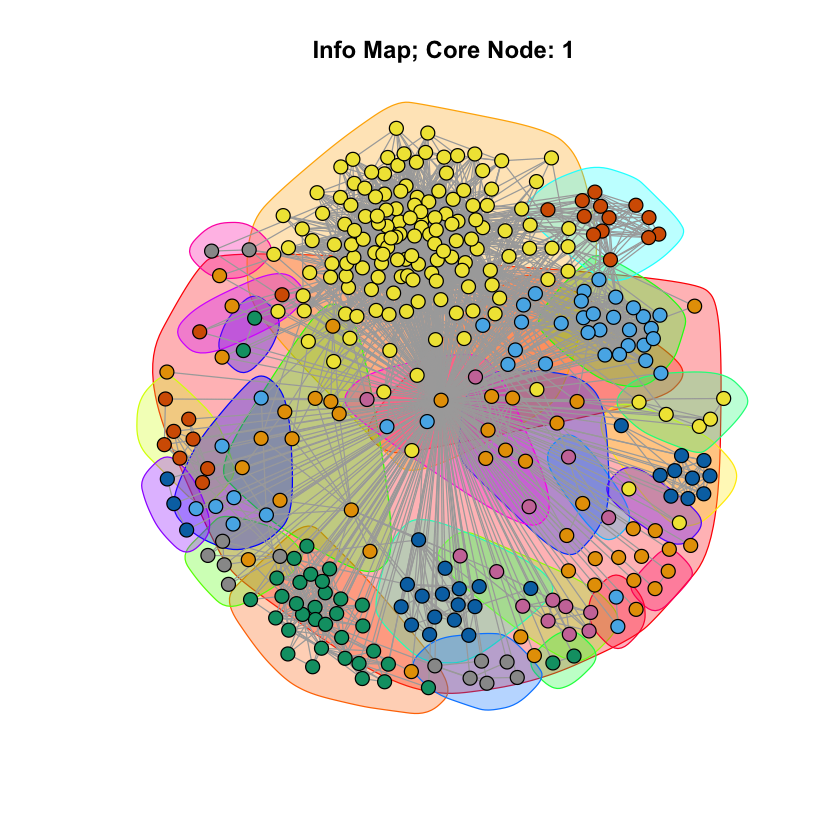

In [28]:
# Community structure of Node ID 1
community_detect(induced.subgraph(g, c(1, neighbors(g,1))), 1)

## Exploring the community structure with the core nodes removed

Node: 1 
[1] "Fast-Greedy Modularity Node 1 is 0.44185326886839"
[1] "Edge-Betweenness Modularity Node 1 is 0.41614614203983"
[1] "Info Map Modularity Node 1 is 0.418007659453891"


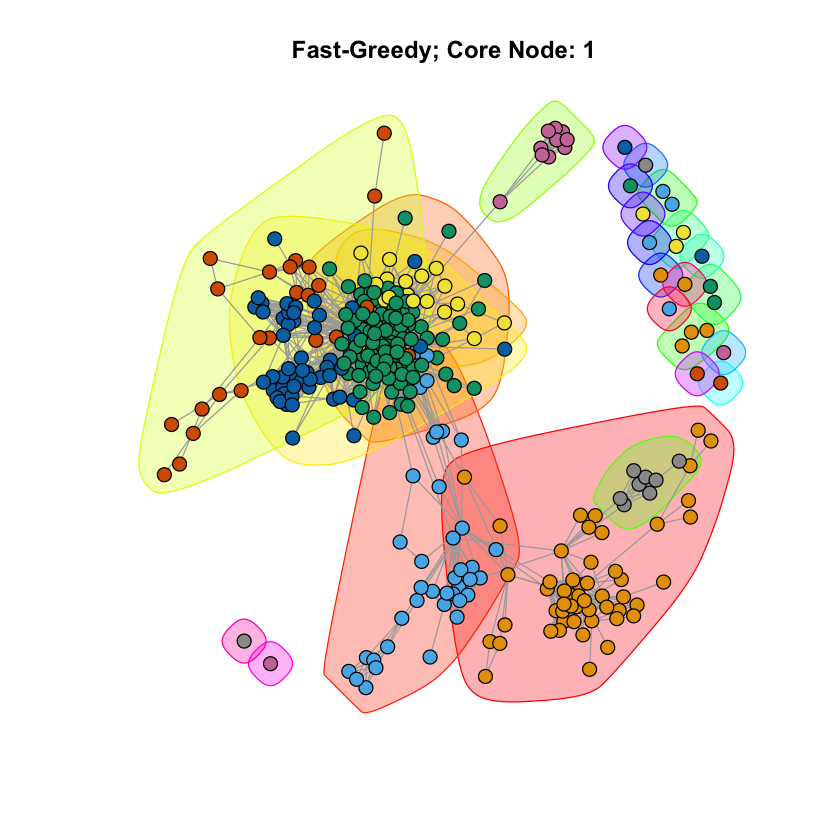

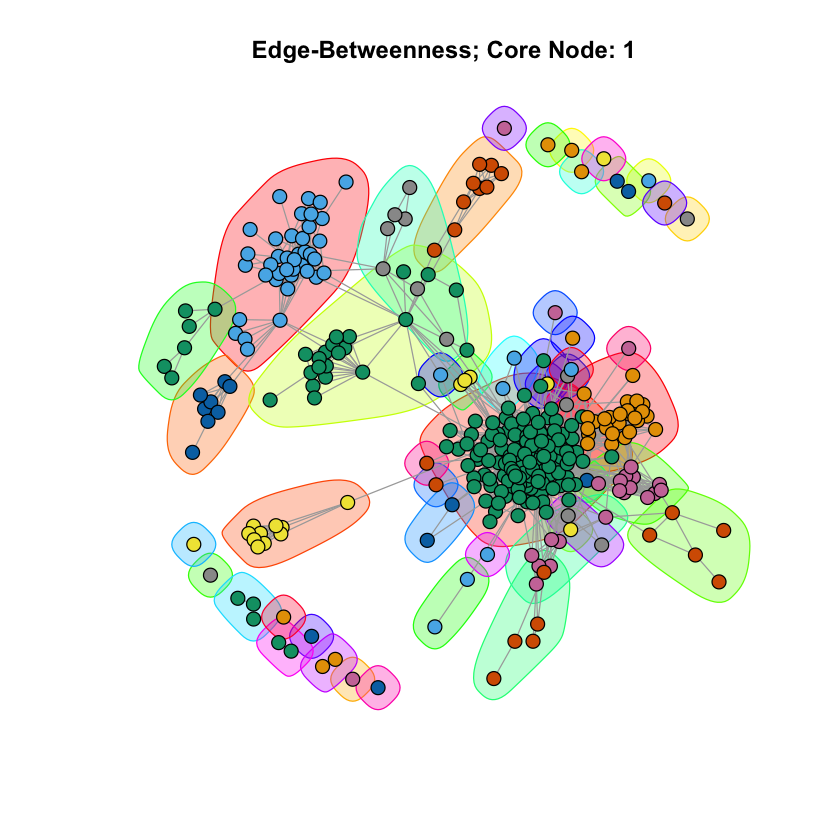

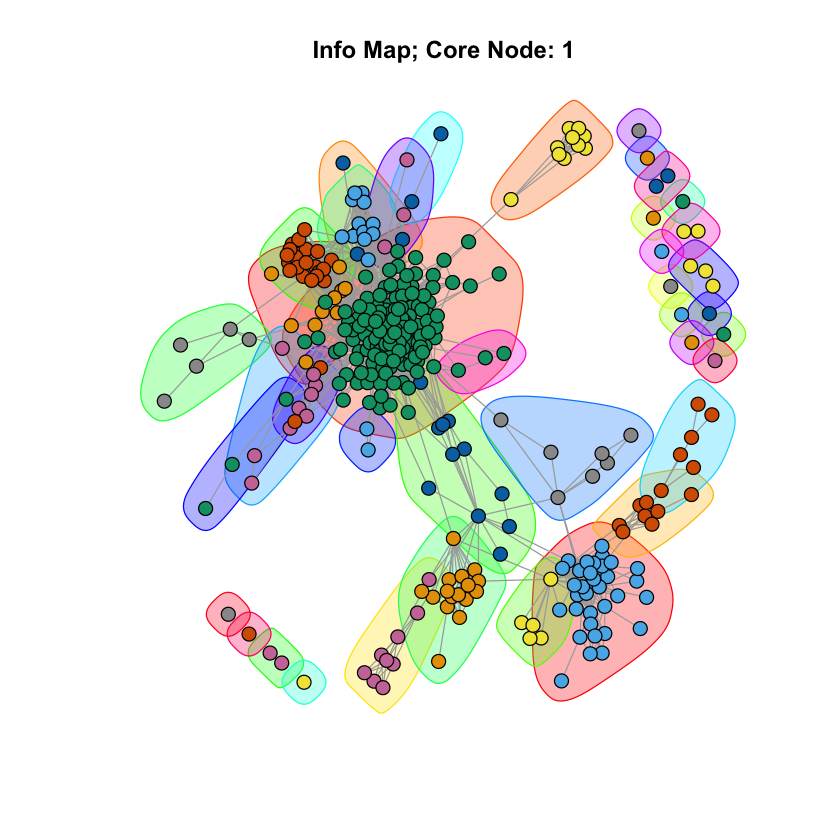

In [29]:
# Community structure with core node 1 removed
community_detect(induced.subgraph(g, neighbors(g,1)), 1)

## Studying embeddedness and dispersion of nodes in the personalized network

In [30]:
## Helper functions for measuring embeddedness and dispersion

#Embeddedness functions
mutual_friends <- function(g, x, y) {
  y_neighbor <- neighbors(g, y)
  x_neighbor <- neighbors(g, x)
  return (intersection(y_neighbor, x_neighbor))
}

embeddedness <- function(g, x, y) {
  return (length(mutual_friends(g, x, y)))
}

#Dispersion function 
dispersion_func <- function(g, node_id) {
  g1 = induced.subgraph(g, c(node_id, neighbors(g, node_id)))
  nei = neighbors(g, node_id)
  d = diameter(g1)
  dispersion = numeric(0)
  embeddedness = numeric(0)

  for(i in 1:length(nei)) {
    embeddedness = c(embeddedness, length(intersect(nei, neighbors(g, nei[i]))))
  }
  for(i in 1:length(nei)) {
    mutual_friends = intersect(nei, neighbors(g, nei[i]))
    delete_vert = delete.vertices(g1, c(which(V(g1)$name == node_id), which(V(g1)$name==nei[i])))
    dist = numeric(0)
    for(x in 1:length(mutual_friends)) {
      for(y in (x + 1):length(mutual_friends)) {
        temp = distances(delete_vert, which(V(delete_vert)$name == mutual_friends[x]), which(V(delete_vert)$name == mutual_friends[y])) 
        if(length(temp) == 0 || is.infinite(temp)) {
          temp = d + 2
        }
        dist = c(dist, temp)  
      }
    }
    dispersion = c(dispersion, sum(dist))
  }
  hist(dispersion[which(dispersion!=Inf)], breaks = 50, main="Dispersion Distribution", xlab="Dispersion")
}

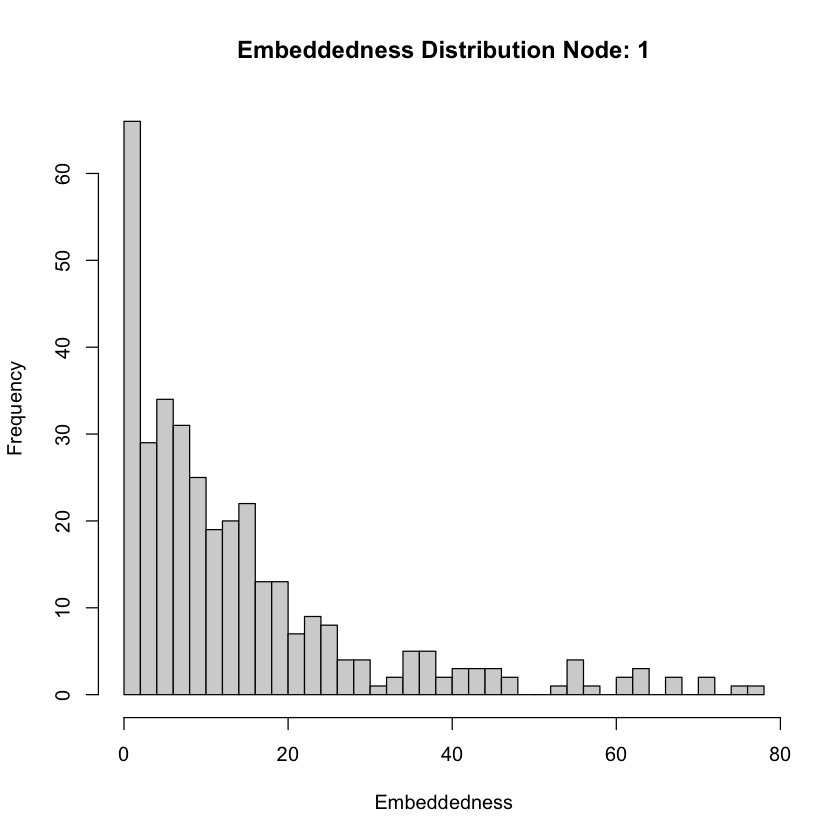

In [31]:
#Plotting embededdness distribution for Node ID 1
node_id = 1
ego_graph = make_ego_graph(g, 1, nodes = node_id)

for (i in 1:length(node_id))
{
  embeddedness = sort(degree(ego_graph[[i]])) - 1
  embeddedness = embeddedness[1:length(embeddedness)-1]
  hist(embeddedness, breaks=50, main=paste("Embeddedness Distribution Node:", node_id[i]), xlab="Embeddedness")
}

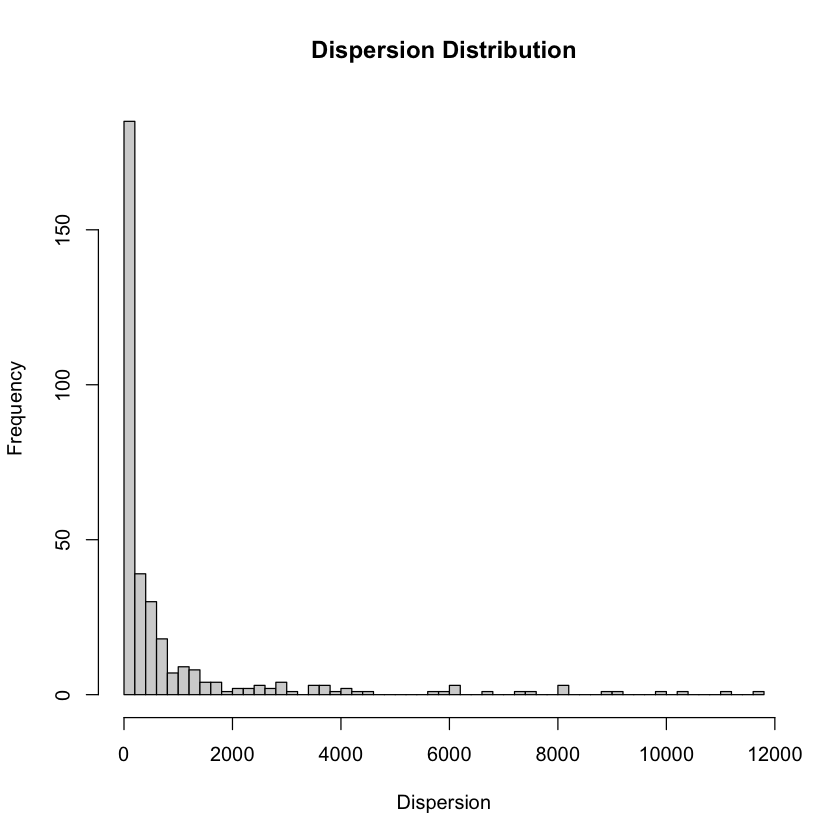

In [32]:
#Plotting dispersion distribution for Node ID 1
dispersion_func(g, 1)